In [1]:
import analyzer.plotting
import peakquality as pq
import pickle
import analyzer
from analyzer.datasets import SampleManager
from analyzer.core import AnalysisResult
import numpy as np
import matplotlib.pyplot as plt
from analyzer.plotting import PlotObject, drawAs1DHist, drawAs2DHist
from hist import Hist

# New things

In [2]:
s = SampleManager()
s.loadSamplesFromDirectory("datasets/")

a_background = AnalysisResult.fromFile("output_background.pkl")
a_background_sculpted_only = AnalysisResult.fromFile("output_background_sculpted_only.pkl")
# hists = a.getMergedHistograms(s)
bg_hists = a_background.getMergedHistograms(s)
bg_hists_sculpted = a_background_sculpted_only.getMergedHistograms(s)

<Figure size 640x480 with 0 Axes>

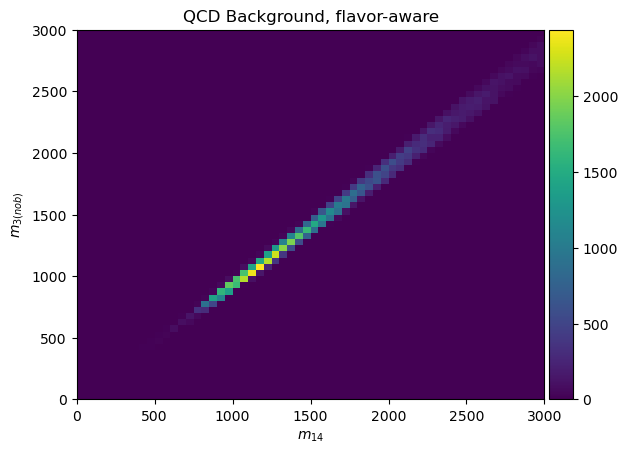

In [5]:
plt.set_cmap("viridis")
bg_hist_aware = bg_hists["m14_vs_m3_top_3_no_lead_b"]
bg_obj_aware = PlotObject.fromHist(bg_hist_aware)

fig, ax = plt.subplots()
ax.title.set_text('QCD Background, flavor-aware')

drawAs2DHist(ax, bg_obj_aware)
plt.show()

<Figure size 640x480 with 0 Axes>

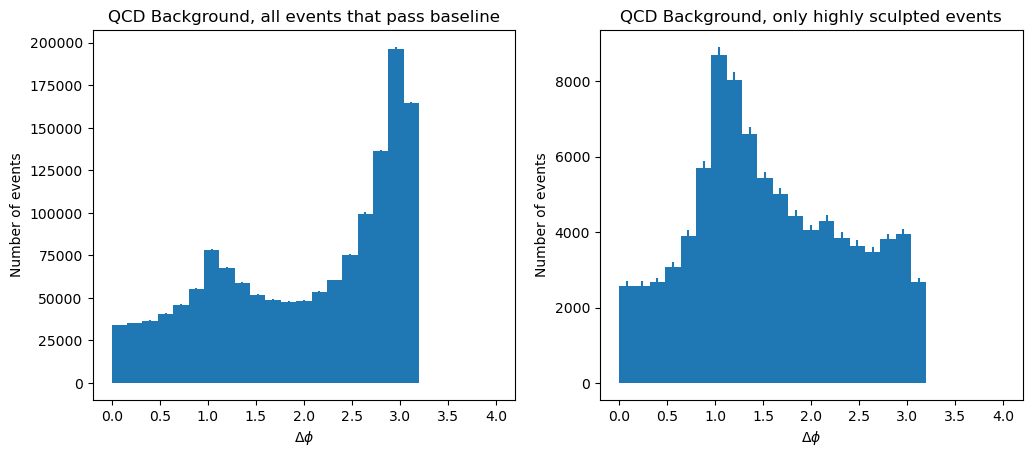

In [6]:
bg_hist = bg_hists["medium_bb_phi"]
sculpted_bg_hist = bg_hists_sculpted["medium_bb_phi"]

bg_obj = PlotObject.fromHist(bg_hist)
bg_obj_sculpted = PlotObject.fromHist(sculpted_bg_hist)

fig, ax = plt.subplots(1, 2)
ax[0].set_title('QCD Background, all events that pass baseline')
ax[1].set_title('QCD Background, only highly sculpted events')

ax[0].set_xlabel('$\Delta \phi$')
ax[0].set_ylabel('Number of events')
ax[1].set_xlabel('$\Delta \phi$')
ax[1].set_ylabel('Number of events')

fig.set_figwidth(12)
drawAs1DHist(ax[0], bg_obj)
drawAs1DHist(ax[1], bg_obj_sculpted)

plt.show()

<Figure size 640x480 with 0 Axes>

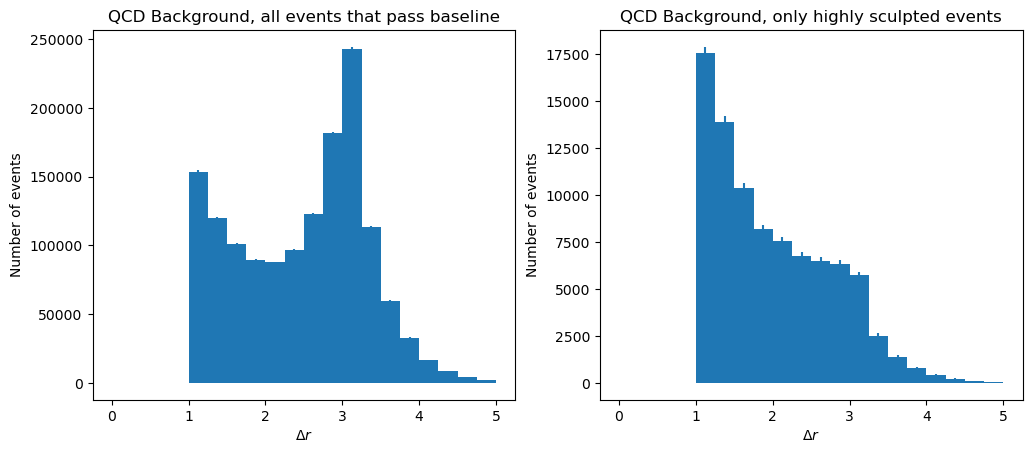

In [7]:
bg_hist = bg_hists["medium_bdr"]
sculpted_bg_hist = bg_hists_sculpted["medium_bdr"]

bg_obj = PlotObject.fromHist(bg_hist)
bg_obj_sculpted = PlotObject.fromHist(sculpted_bg_hist)

fig, ax = plt.subplots(1, 2)
ax[0].set_title('QCD Background, all events that pass baseline')
ax[1].set_title('QCD Background, only highly sculpted events')

ax[0].set_xlabel('$\Delta r$')
ax[0].set_ylabel('Number of events')
ax[1].set_xlabel('$\Delta r$')
ax[1].set_ylabel('Number of events')

fig.set_figwidth(12)
drawAs1DHist(ax[0], bg_obj)
drawAs1DHist(ax[1], bg_obj_sculpted)

plt.show()

<Figure size 640x480 with 0 Axes>

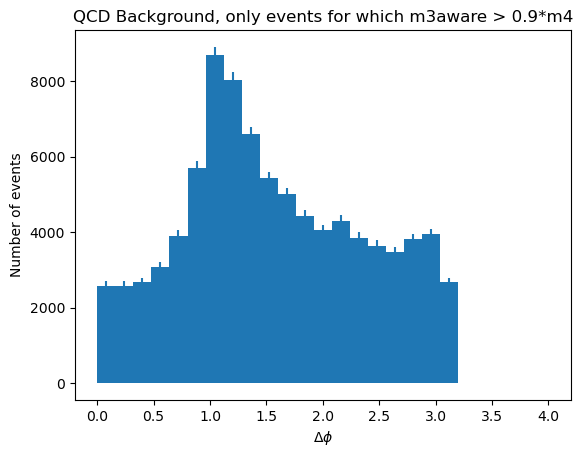

In [9]:
plt.set_cmap("viridis")
bg_hist_aware = bg_hists["medium_bb_phi"]
bg_obj_aware = PlotObject.fromHist(bg_hist_aware)

fig, ax = plt.subplots()
ax.title.set_text('QCD Background, only events for which m3aware > 0.9*m4')

ax.set_xlabel('$\Delta \phi$')
ax.set_ylabel('Number of events')
drawAs1DHist(ax, bg_obj_aware)
plt.show()

# Weird stuff

In [2]:
def makeCutSet(x, s, *args):
    return [x[s > a] for a in args]

b_tag_wps = [0.0490, 0.2783, 0.7100]

def createObjects(events):
    good_jets = events.Jet[(events.Jet.pt > 30) & (abs(events.Jet.eta) < 2.4)]
    fat_jets = events.FatJet[(events.FatJet.pt > 30) & (abs(events.FatJet.eta) < 2.4)]
    loose_top, med_top, tight_top = makeCutSet(
        fat_jets, fat_jets.particleNet_TvsQCD, 0.58, 0.80, 0.97
    )
    #loose_W, med_W, tight_W = makeCutSet(
    #    fat_jets, fat_jets.particleNet_WvsQCD, 0.7, 0.94, 0.98
    #)

    #deep_top_wp1, deep_top_wp2, deep_top_wp3, deep_top_wp4 = makeCutSet(
    #    fat_jets, fat_jets.deepTag_TvsQCD, 0.436, 0.802, 0.922, 0.989
    #)
    #deep_W_wp1, deep_W_wp2, deep_W_wp3, deep_W_wp4 = makeCutSet(
    #    fat_jets, fat_jets.deepTag_WvsQCD, 0.458, 0.762, 0.918, 0.961
    #)
    loose_b, med_b, tight_b = makeCutSet(
        good_jets, good_jets.btagDeepFlavB, *(b_tag_wps[x] for x in range(3))
    )

    el = events.Electron
    good_electrons = el[
        (el.cutBased == 4)
        & (el.miniPFRelIso_all < 0.1)
        & (el.pt > 30)
        & (abs(el.eta) < 2.4)
    ]
    mu = events.Muon
    good_muons = mu[
        (mu.mediumId) & (mu.miniPFRelIso_all < 0.2) & (mu.pt > 30) & (abs(mu.eta) < 2.4)
    ]
    events["good_jets"] = good_jets
    events["good_electrons"] = good_electrons
    events["good_muons"] = good_muons

    events["loose_bs"] = loose_b
    events["med_bs"] = med_b
    events["tight_bs"] = tight_b

    events["tight_tops"] = tight_top
    # events["med_tops"] = med_top
    # events["loose_tops"] = loose_top

    # events["tight_Ws"] = tight_W
    # events["med_Ws"] = med_W
    # events["loose_Ws"] = loose_W

    # events["deep_top_wp1"] = deep_top_wp1
    # events["deep_top_wp2"] = deep_top_wp2
    # events["deep_top_wp3"] = deep_top_wp3
    # events["deep_top_wp4"] = deep_top_wp4

    # events["deep_W_wp1"] = deep_W_wp1
    # events["deep_W_wp2"] = deep_W_wp2
    # events["deep_W_wp3"] = deep_W_wp3
    # events["deep_W_wp4"] = deep_W_wp4

    return events

def createSelection(events):
    """Baseline selection for the analysis.
Applies the following selection:
- Jets[0].pt > 300
- 4 <= nJets <= 6
- 0 leptons
- 2 medium bjets, at least one of which is tight
- delta_R(med_bjets[0],med_bjets[1]) > 1
    """

    selection = PackedSelection()
    good_jets = events.good_jets
    fat_jets = events.FatJet
    good_muons = events.good_muons
    good_electrons = events.good_electrons
    loose_b = events.loose_bs
    med_b = events.med_bs
    tight_b = events.tight_bs
    tight_top = events.tight_tops
    # selection = PackedSelection()
    filled_jets = ak.pad_none(good_jets, 4, axis=1)
    top_two_dr = ak.fill_none(filled_jets[:, 0].delta_r(filled_jets[:, 1]), False)

    filled_med = ak.pad_none(med_b, 2, axis=1)
    med_dr = ak.fill_none(filled_med[:, 0].delta_r(filled_med[:, 1]), False)
    # selection.add("trigger", (ak.num(good_jets) >= 4) & (ak.num(good_jets) <= 6))
    if "HLT" in events.fields:
        selection.add("hlt", (events.HLT.PFHT1050 | events.HLT.AK8PFJet360_TrimMass30))
    selection.add("highptjet", (ak.fill_none(filled_jets[:, 0].pt > 300, False)))
    selection.add("jets", ((ak.num(good_jets) >= 4) & (ak.num(good_jets) <= 6)))
    selection.add("0Lep", ((ak.num(good_electrons) == 0) & (ak.num(good_muons) == 0)))
    selection.add("2bjet", (ak.num(med_b) >= 2))
    selection.add("1tightbjet", (ak.num(tight_b) >= 1))
    # selection.add("jet_dr", ((top_two_dr < 4) & (top_two_dr > 2)).to_numpy())
    selection.add("b_dr", (med_dr > 1))
    return selection

In [9]:
bgdata = AnalysisResult.fromFile("output_background.pkl")

In [26]:
bgdata.results

{'Skim_QCDInclusive2018_HT500to700': DatasetRunResult(dataset_preprocessed=DatasetPreprocessed(dataset_input=AnalyzerInput(dataset_name='Skim_QCDInclusive2018_HT500to700', fill_name='Skim_QCDInclusive2018', coffea_dataset={'Skim_QCDInclusive2018_HT500to700': {'files': {'/local/cms/user/ckapsiak/SingleStop/datafiles/Skims_2023_09_05//RunIISummer20UL18NanoAODv9_QCD_HT500to700.root': 'Events'}}}, lumi_json=None), coffea_dataset_split={'files': {'/local/cms/user/ckapsiak/SingleStop/datafiles/Skims_2023_09_05//RunIISummer20UL18NanoAODv9_QCD_HT500to700.root': {'object_path': 'Events', 'steps': [[0, 234]], 'num_entries': 234, 'uuid': '6875104a-4bc8-11ee-a96f-95bde183beef'}}, 'form': None, 'metadata': None}), histograms={'m3_top_3_no_lead_b': Hist(Regular(60, 0, 3000, name='mass of jets 1-3 without leading b'), storage=Weight()) # Sum: WeightedSum(value=234, variance=234), 'm14_vs_m3_top_3_no_lead_b': Hist(
   Regular(60, 0, 3000, name='$m_{14}$'),
   Regular(60, 0, 3000, name='$m_{3 (no b)}$'